In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

pd.options.display.max_columns = 500

### Загрузим датасет с машинами. Цель - верно восстанавливать для каждой из них цену продажи!

In [3]:
data = pd.read_csv('autos.csv')

data

,name,year,selling_price,km_driven,fuel,seller_type,transmission,owner
0,Maruti 800 AC,2007,60000,70000,Petrol,Individual,Manual,First Owner
1,Maruti Wagon R LXI Minor,2007,135000,50000,Petrol,Individual,Manual,First Owner
2,Hyundai Verna 1.6 SX,2012,600000,100000,Diesel,Individual,Manual,First Owner
3,Datsun RediGO T Option,2017,250000,46000,Petrol,Individual,Manual,First Owner
4,Honda Amaze VX i-DTEC,2014,450000,141000,Diesel,Individual,Manual,Second Owner
...,...,...,...,...,...,...,...,...
4335,Hyundai i20 Magna 1.4 CRDi (Diesel),2014,409999,80000,Diesel,Individual,Manual,Second Owner
4336,Hyundai i20 Magna 1.4 CRDi,2014,409999,80000,Diesel,Individual,Manual,Second Owner
4337,Maruti 800 AC BSIII,2009,110000,83000,Petrol,Individual,Manual,Second Owner
4338,Hyundai Creta 1.6 CRDi SX Option,2016,865000,90000,Diesel,Individual,Manual,First Owner


In [4]:
### Колонка с тергетом - "selling price"

X = data.drop("selling_price", axis=1)
y = data["selling_price"]

### Будем замерять MSLE!
### Поэтому прологарифмируем таргет
### А после оптимизируем MSE

y = y.apply(np.log1p)

In [5]:
### Разделим выборку на трейн и тест!

from sklearn.model_selection import train_test_split 

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

__Задание__ 

Реализуйте свой MeanTargetEncoder с добавленем некоторого шума!

Однажды в лекционном материале, обсуждая счетчики, мы говорили с вами о том, что из-за них модели могут переобучаться. Один из способов бороться с этим - валидировать расчеты среднего таргета (стратегия отложенной выборки / расчеты на кросс-валидации). Но есть еще проще!

Можно просто к значению счетчика добавить случайный шум (зашумить данные)!

Напомним, что рассчитываться новые признаки должны по такой формуле:

$$
g_j = \frac{\sum_{i=1}^{l} [f_j(x) = f_j(x_i)]}{l} + C * \epsilon
$$


Пусть шум будет случайной величиной из нормального стандартного распределения, то есть $\epsilon \sim N(0, 1) $, а $ C = 0.006$.

Создавай свой класс-трансформер, наследуйтесь от классов `BaseEstimator, TransformerMixin` из `sklearn.base`. Трансформер не должен модифицировать передаваемую ему выборку inplace, а все необходимые статистики нужно считать только по обучающей выборке в методе `fit`. 
Ваш трансформер должен принимать при инициализации список из категориальных признаков и список из числовых признаков. 

Если для какого-то признака в тестовой выборке отсутствует значение, трансформер должен поставить там 0.

На выходе должен получиться датасет того же размера с измененными категориальными признаками

In [6]:
object_cols = ['name', 'year', 'fuel', 'seller_type', 'transmission', 'owner']
num_cols = ['km_driven']

X.nunique()

name            1491
year              27
km_driven        770
fuel               5
seller_type        3
transmission       2
owner              5
dtype: int64

In [7]:
from sklearn.base import BaseEstimator, TransformerMixin

class MeanTargetEncoderNoise(BaseEstimator, TransformerMixin):
    
    def __init__(self, categorical, numeric):
        
        self.categorical = categorical
        self.numeric = numeric
        
    
    def fit(self, X, y):
        
        Xy_fit = X.copy().join(y.copy())
        self.mean_dict = {col: Xy_fit.groupby(col)['selling_price'].mean() for col in self.categorical}
        return self
  

    def transform(self, df):
        
        temp = df.copy()
        
        for col in self.categorical:
            
            temp[col] = temp[col].map(self.mean_dict[col])
            temp[col] = temp[col]  +  0.006 * np.random.randn()
            temp[col] = temp[col].fillna(0)
            
        return temp

In [8]:
### Проверка работы трансформера

np.random.seed(1)
transformer = MeanTargetEncoderNoise(categorical=object_cols, numeric=num_cols)

transformer.fit(X_train, y_train)

train = transformer.transform(X_train)
test = transformer.transform(X_test)

test

,name,year,km_driven,fuel,seller_type,transmission,owner
2761,13.677479,13.548297,15000,13.091037,12.616600,12.646961,12.960574
3210,13.050631,12.924308,70000,13.091037,12.616600,12.646961,12.447828
2606,13.133030,12.622395,90000,13.091037,12.616600,12.646961,12.960574
1030,12.395071,13.130976,41000,12.455263,13.145823,12.646961,12.960574
3942,13.388497,12.924308,71318,13.091037,13.145823,12.646961,12.960574
...,...,...,...,...,...,...,...
1206,12.157311,12.413142,80000,12.455263,12.616600,12.646961,12.447828
3167,12.622010,12.856188,90000,13.091037,12.616600,12.646961,12.447828
1297,0.000000,12.152245,60000,13.091037,12.616600,12.646961,12.109128
2188,13.457151,13.052781,66521,12.455263,13.639347,12.646961,12.960574


Обучите несколько деревьев, перебирая максимальную глубину алгоритма из списка `max_depth_list`, а остальные параметры оставьте дефолтными. Выведите лучшее значение гиперпараметра. Постройте график зависимости MSLE на тестовой выборке от значения гиперпараметра. Воспользуйтесь `Pipeline` без `GridSearch`. Проделайте то же самое с `min_samples_split`, `min_impurity_decrease`, `max_leaf_nodes`. (по 2б на каждый параметр)

In [9]:
max_depth_list = [3, 5, 8, 12]
min_samples_split_list = [10, 50, 100, 500]
min_impurity_decrease_list = [0, 0.1, 0.15, 0.2]
max_leaf_nodes_list = [100, 200, 500]

param_grid = {
    "max_depth": [3, 5, 8, 12],
    "min_samples_split": [10, 50, 100, 500],
    "min_impurity_decrease": [0, 0.1, 0.15, 0.2],
    "max_leaf_nodes": [100, 200, 500]}

param_grid = {k: [{k: j} for j in i] for k, i in param_grid.items()}

param_grid['max_depth']

[{'max_depth': 3}, {'max_depth': 5}, {'max_depth': 8}, {'max_depth': 12}]

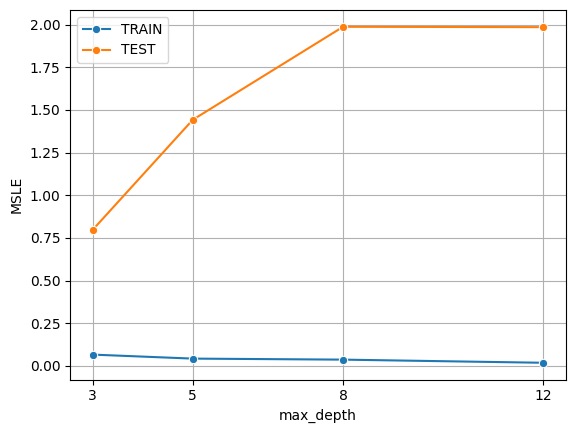

,max_depth,msle_train,msle_test
0,3.0,0.066,0.797
1,5.0,0.043,1.442
2,8.0,0.037,1.987
3,12.0,0.018,1.985


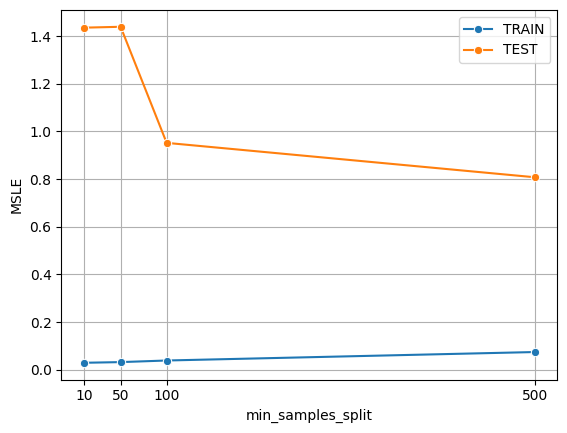

,min_samples_split,msle_train,msle_test
0,10.0,0.030,1.435
1,50.0,0.033,1.439
2,100.0,0.039,0.952
3,500.0,0.075,0.808


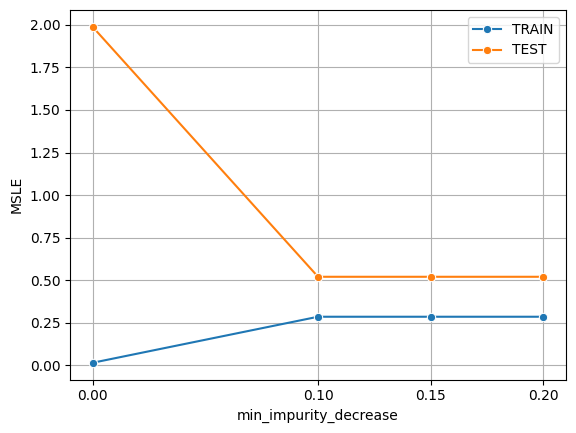

,min_impurity_decrease,msle_train,msle_test
0,0.00,0.016,1.988
1,0.10,0.286,0.520
2,0.15,0.286,0.520
3,0.20,0.286,0.520


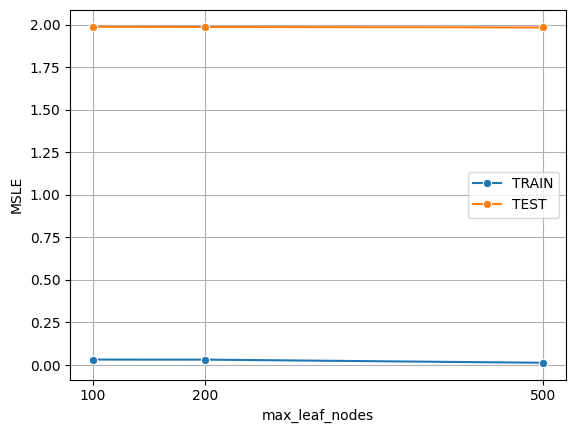

,max_leaf_nodes,msle_train,msle_test
0,100.0,0.032,1.988
1,200.0,0.032,1.987
2,500.0,0.013,1.984


In [10]:
from sklearn.metrics import mean_squared_error as mse
from sklearn.tree import DecisionTreeRegressor
from sklearn.pipeline import Pipeline

np.random.seed(1)

for k in param_grid.keys():
    
    res = pd.DataFrame({k: np.zeros(len(param_grid[k])),
                        'msle_train': np.zeros(len(param_grid[k])),
                        'msle_test': np.zeros(len(param_grid[k]))})
    
    n = 0
    
    for i in param_grid[k]:
        
        res.loc[n, k] = i[k]
        n += 1
        
        pipe = Pipeline([('MHE', MeanTargetEncoderNoise(object_cols, num_cols)),
                 ('decision_tree', DecisionTreeRegressor(**i))])
    
        pipe.fit(X_train, y_train)
    
        msle_train = np.mean((y_train - pipe.predict(X_train))**2)
        res.loc[res[k] == i[k], 'msle_train'] = msle_train
        
        msle_test = np.mean((y_test - pipe.predict(X_test))**2)
        res.loc[res[k] == i[k], 'msle_test'] = msle_test
        
    
    sns.lineplot(x=res[k], y=res['msle_train'], marker='o', label='TRAIN')
    sns.lineplot(x=res[k], y=res['msle_test'], marker='o', label='TEST')
    plt.xticks(res[k])
    plt.grid()
    plt.ylabel('MSLE')
    plt.legend()
        
    plt.show()
    display(res.round(3))
    print('\n\n\n')

Подберите лучшую комбинацию параметров, используя `GridSearchCV` и набор массивов значений параметров из предыдущего задания. Для лучшей комбинации посчитайте MSLE на тестовой выборке. Получились ли лучшие параметры такими же, как если бы вы подбирали их по-отдельности при остальных гиперпараметрах по умолчанию (предыдущее задание)? (2б)

In [11]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    "decision_tree__max_depth": [3, 5, 8, 12],
    "decision_tree__min_samples_split": [10, 50, 100, 500],
    "decision_tree__min_impurity_decrease": [0, 0.1, 0.15, 0.2],
    "decision_tree__max_leaf_nodes": [100, 200, 500]
}
np.random.seed(1)

search = GridSearchCV(pipe, param_grid=param_grid)

search.fit(X_train, y_train)

error = mse(y_test, search.predict(X_train))





In [ ]:
ms